In [74]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit

In [75]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))  # risale a ex_b
RESULTS_DIR = os.path.join(BASE_DIR, 'results')


In [76]:
# Configura matplotlib per grafici professionali
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['lines.linewidth'] = 1.5

def read_csv_data(filename):
    """Legge dati dal CSV"""
    if not os.path.exists(filename):
        print(f"⚠ File {filename} non trovato")
        return None, None, None
    
    threads, times, sizes = [], [], []
    with open(filename, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            threads.append(int(row['threads']))
            times.append(float(row['time']))
            sizes.append((int(row['width']), int(row['height'])))
    
    return threads, times, sizes


In [77]:
def fit_amdahl_law(threads, speedups):
    def amdahl_func(p, f):
        return 1 / (f + (1 - f) / p)
    try:
        popt, _ = curve_fit(amdahl_func, threads, speedups, bounds=([0], [1]), maxfev=10000)
        return popt[0]
    except:
        return 0.01

def fit_gustafson_law(threads, scaled_speedups):
    def gustafson_func(p, s):
        return s + (1 - s) * p
    try:
        popt, _ = curve_fit(gustafson_func, threads, scaled_speedups, maxfev=10000)
        return popt[0]
    except:
        slope = (scaled_speedups[-1] - scaled_speedups[0]) / (threads[-1] - threads[0])
        intercept = scaled_speedups[0] - slope * threads[0]
        return max(0, min(1, intercept))

In [78]:
def create_strong_scaling_plot():
    data = read_csv_data(os.path.join(RESULTS_DIR, 'omp_strong_scaling.csv'))
    if not data[0]:
        print("⚠ Dati strong scaling non disponibili")
        return
    
    threads, times, _ = data
    threads = np.array(threads)
    times = np.array(times)
    seq_time = times[0]
    speedups = seq_time / times
    efficiencies = speedups / threads
    serial_fraction = fit_amdahl_law(threads, speedups)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('STRONG OMP Threads vs Speedup', fontsize=14, y=0.95)
    ax1.scatter(threads, speedups, color='#1f77b4', s=15, alpha=0.8, zorder=3)
    thread_range = np.linspace(1, max(threads), 200)
    theoretical_speedup = 1 / (serial_fraction + (1 - serial_fraction) / thread_range)
    ax1.plot(thread_range, theoretical_speedup, 'k-', linewidth=1.2, alpha=0.8,
             label=f"Amdahl's law: y = 1/(({serial_fraction:.2f})T + {1-serial_fraction:.2f})")
    ax1.set_xlabel('Number of Threads')
    ax1.set_ylabel('Speedup')
    ax1.set_title('STRONG OMP Threads vs Speedup')
    ax1.legend(loc='lower right', fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, max(threads) + 5)
    ax1.set_ylim(0, max(speedups) * 1.1)
    ax1.text(0.75 * max(threads), 0.25 * max(speedups), 
             f'f = {serial_fraction:.3f}', fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
    
    ax2.scatter(threads, efficiencies, color='#1f77b4', s=15, alpha=0.8, zorder=3)
    ax2.axhline(y=1.0, color='black', linestyle='--', alpha=0.6, label='Ideal Efficiency')
    avg_eff = np.mean(efficiencies)
    ax2.axhline(y=avg_eff, color='black', linestyle='-', alpha=0.8,
                label=f'Avg efficiency: {avg_eff:.2f}')
    ax2.set_xlabel('Number of Threads') 
    ax2.set_ylabel('Efficiency')
    ax2.set_title('STRONG OMP Threads vs Efficiency')
    ax2.legend(loc='upper right', fontsize=9)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, max(threads) + 5)
    ax2.set_ylim(0, 1.05)
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'strong_scaling_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()
    return serial_fraction


In [ ]:
def create_weak_scaling_plot():
    data = read_csv_data(os.path.join(RESULTS_DIR, 'omp_weak_scaling.csv'))
    if not data[0]:
        print("⚠ Dati weak scaling non disponibili")
        return
    
    threads, times, sizes = data
    threads = np.array(threads)
    times = np.array(times)
    baseline_time = times[0]
    efficiencies = baseline_time / times
    scaled_speedups = efficiencies * threads
    serial_fraction = fit_gustafson_law(threads, scaled_speedups)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('WEAK OMP Threads vs Scaled Speedup', fontsize=14, y=0.95)
    ax1.scatter(threads, scaled_speedups, color='#ff7f0e', s=15, alpha=0.8, zorder=3)
    thread_range = np.linspace(1, max(threads), 200)
    theoretical_scaled = serial_fraction + (1 - serial_fraction) * thread_range
    ax1.plot(thread_range, theoretical_scaled, 'k-', linewidth=1.2, alpha=0.8,
             label=f"Gustafson's law: y = ({serial_fraction:.3f})T + {1-serial_fraction:.2f}")
    ax1.set_xlabel('Number of Threads')
    ax1.set_ylabel('Scaled Speedup')
    ax1.set_title('WEAK OMP Threads vs Scaled Speedup')
    ax1.legend(loc='lower right', fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, max(threads) + 5)
    ax1.set_ylim(0, max(scaled_speedups) * 1.1)
    ax1.text(0.75 * max(threads), 0.25 * max(scaled_speedups),
             f'f = {serial_fraction:.3f}', fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
    
    ax2.scatter(threads, efficiencies, color='#ff7f0e', s=15, alpha=0.8, zorder=3)
    ax2.axhline(y=1.0, color='black', linestyle='--', alpha=0.6, label='Ideal Efficiency')
    avg_eff = np.mean(efficiencies)
    ax2.axhline(y=avg_eff, color='black', linestyle='-', alpha=0.8,
                label=f'Avg efficiency: {avg_eff:.2f}')
    ax2.set_xlabel('Number of Threads')
    ax2.set_ylabel('Efficiency')
    ax2.set_title('WEAK OMP Threads vs Efficiency')
    ax2.legend(loc='upper right', fontsize=9)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, max(threads) + 5)
    ax2.set_ylim(0, 1.05)
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'weak_scaling_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()
    return serial_fraction

def print_analysis_summary():
    print("=" * 80)
    print("ANALISI SCALING MANDELBROT OPENMP")
    print("=" * 80)
    
    strong_data = read_csv_data(os.path.join(RESULTS_DIR, 'omp_strong_scaling.csv'))
    if strong_data[0]:
        threads, times, _ = strong_data
        seq_time = times[0]
        speedups = [seq_time / t for t in times]
        efficiencies = [(s / t) * 100 for s, t in zip(speedups, threads)]
        
        print(f"\nSTRONG SCALING:")
        print(f"• Speedup massimo: {max(speedups):.1f}x")
        print(f"• Efficienza massima: {max(efficiencies):.1f}%")
        print(f"• Thread con efficienza ≥80%: {len([e for e in efficiencies if e >= 80])}")
        print(f"• Thread con efficienza ≥60%: {len([e for e in efficiencies if e >= 60])}")
    
    weak_data = read_csv_data(os.path.join(RESULTS_DIR, 'omp_weak_scaling.csv'))
    if weak_data[0]:
        threads, times, _ = weak_data
        baseline = times[0]
        efficiencies = [(baseline / t) for t in times]
        
        print(f"\nWEAK SCALING:")
        print(f"• Efficienza finale: {efficiencies[-1]:.3f}")
        print(f"• Efficienza media: {np.mean(efficiencies):.3f}")
        print(f"• Variazione tempo: {((times[-1] - baseline) / baseline) * 100:+.1f}%")
        print(f"• Thread con efficienza ≥80%: {len([e for e in efficiencies if e >= 0.8])}")

Generazione grafici scaling analysis...

1. Generando grafico strong scaling...


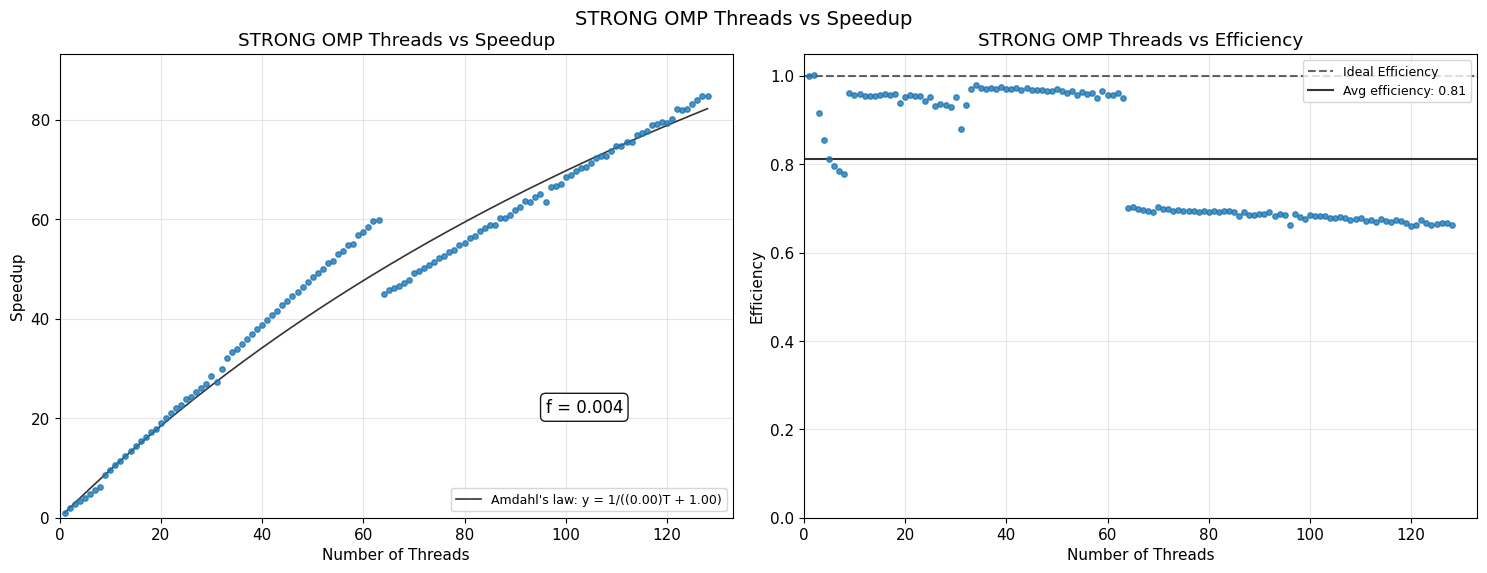

   ✓ Strong scaling: frazione seriale = 0.004

2. Generando grafico weak scaling...


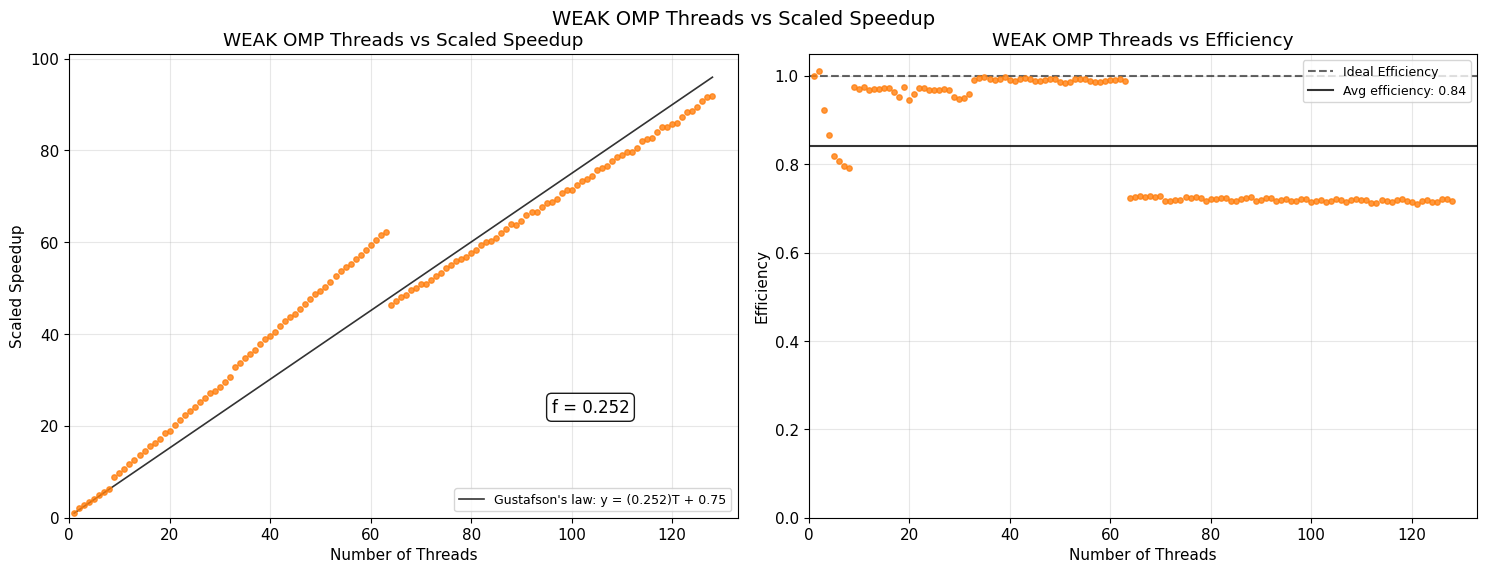

   ✓ Weak scaling: frazione seriale = 0.252
ANALISI SCALING MANDELBROT OPENMP

STRONG SCALING:
• Speedup massimo: 84.8x
• Efficienza massima: 100.2%
• Thread con efficienza ≥80%: 60
• Thread con efficienza ≥60%: 128

WEAK SCALING:
• Efficienza finale: 0.718
• Efficienza media: 0.841
• Variazione tempo: +39.3%
• Thread con efficienza ≥80%: 61

✓ Grafici salvati in /home/robertalamberti/HPC-project/ex2/ex_b/results
  - strong_scaling_analysis.png
  - weak_scaling_analysis.png


In [80]:
def main():
    os.makedirs(RESULTS_DIR, exist_ok=True)
    
    print("Generazione grafici scaling analysis...")
    print("=" * 50)
    
    print("\n1. Generando grafico strong scaling...")
    serial_fraction_strong = create_strong_scaling_plot()
    if serial_fraction_strong:
        print(f"   ✓ Strong scaling: frazione seriale = {serial_fraction_strong:.3f}")
    
    print("\n2. Generando grafico weak scaling...")
    serial_fraction_weak = create_weak_scaling_plot()
    if serial_fraction_weak:
        print(f"   ✓ Weak scaling: frazione seriale = {serial_fraction_weak:.3f}")
    
    print_analysis_summary()
    
    print(f"\n✓ Grafici salvati in {RESULTS_DIR}")
    print("  - strong_scaling_analysis.png")
    print("  - weak_scaling_analysis.png")

if __name__ == "__main__":
    main()